# Categorizing user complaints of the four largest telecommunications companies in South Africa using Topic Modelling

> ℹ️ Source Code

The recommended approach to running the code is to clone the git repository from https://github.com/JohnnyFoulds/dsm020-2021-oct and open it in Visual Studio Code as a [Development Container](https://code.visualstudio.com/docs/remote/create-dev-container). This will create an environment identical to what has been used during development. This notebook is located at `/workspaces/dsm020-2021-oct/coursework_02/cw.ipynb` in the development container.

The following packages were added explicitly to the development container and will be required to execute the notebook if it is to be executed outside of VS Code.

[requirements.txt](https://github.com/JohnnyFoulds/dsm020-2021-oct/blob/master/requirements.txt)

```
ipykernel==6.4.1
ipywidgets==7.6.3
nltk==3.6.5
matplotlib==3.4.3
pandas==1.3.4
openpyxl==3.0.9
pyquery==1.4.3
requests==2.26.0
scikit-learn==0.23.2
plotly==5.4.0
pycaret==2.3.5
shap==0.40.0
pyarrow==6.0.1
bs4==0.0.1
fasttext==0.9.2
```

In [60]:
## import libraries
import pandas as pd
from pycaret.nlp import *
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

> ❗ Please be sure to execute the following lines since `pycaret.nlp` requires english language model. A kernel restart might be required after the models have been downloaded.

In [3]:
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora

Defaulting to user installation because normal site-packages is not writeable
  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package brown to /home/vscode/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/vscode/nltk_data...
[nltk_data]   Package conll2000 is already up-

## Appendix A: Web References

The folling is a list of technical resources that were consulted.

### Topic Modelling

- [Matti Lyra - Evaluating Topic Models](https://www.youtube.com/watch?v=UkmIljRIG_M)
- [Bhargav Srinivasa Desikan - Topic Modelling (and more) with NLP framework Gensim](https://www.youtube.com/watch?v=ZkAFJwi-G98)
- [Gensim - Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamodel.html)

### Pycaret

- [Topic Modeling on PyCaret](https://towardsdatascience.com/topic-modeling-on-pycaret-2ce0c65ba3ff)
- [Natural Language Processing Tutorial (NLP101) - Level Beginner](https://github.com/pycaret/pycaret/blob/master/tutorials/Natural%20Language%20Processing%20Tutorial%20Level%20Beginner%20-%20NLP101.ipynb)
- [Natural Language Processing Tutorial (NLP102) - Level Intermediate](https://github.com/pycaret/pycaret/blob/master/tutorials/Natural%20Language%20Processing%20Tutorial%20Level%20Intermediate%20-%20NLP102.ipynb)

### Plots

- [seaborn - Example gallery](https://seaborn.pydata.org/examples/index.html)

### Dataset

- [How to balance a dataset in Python](https://towardsdatascience.com/how-to-balance-a-dataset-in-python-36dff9d12704)

## III. Experimental Setup

In [61]:
random_seed = 2480

### A. Data Collection and Per-Processing


The Hellopeter telecommunications dataset prepared in coursework 1 is loaded from the GitHub repository.

In [4]:
# load the raw datasets retrieved fom hellopeter
telecom_reviews = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/raw/master/coursework_01/data/output/telecommunications.gzip')
telecom_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35072 entries, 0 to 35071
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          35072 non-null  object        
 1   created_at                  35072 non-null  datetime64[ns]
 2   author                      35072 non-null  object        
 3   author_id                   35072 non-null  object        
 4   review_title                35072 non-null  object        
 5   review_rating               35072 non-null  int64         
 6   review_content              35072 non-null  object        
 7   business_slug               35072 non-null  object        
 8   permalink                   35072 non-null  object        
 9   replied                     35072 non-null  bool          
 10  messages                    35072 non-null  object        
 11  industry_slug               35072 non-null  object    

#### 1) Discard the subsample of 4-5 reviews as these are considered compliments

[Text(0.5, 1.0, 'Review Star Ratings'),
 Text(0.5, 0, 'Star Rating'),
 Text(0, 0.5, 'Count')]

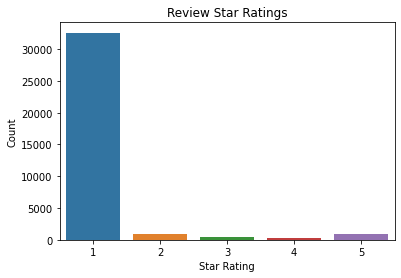

In [48]:
sns.countplot(
    data=telecom_reviews,
    x='review_rating').set(
    title='Review Star Ratings',
    xlabel='Star Rating',
    ylabel='Count')

In [77]:
def show_remaining_count(original, filtered):
    """
    Show information of data data rows remaining after filtering have been applied to the original dataset.

    Parameters
    ----------
    original : pandas.DataFrame
        The unfiltered dataset.
    filtered : pandas.DataFrame
        The filtered dataset.
    """
    count_original = original.shape[0]
    count_filtered = filtered.shape[0]

    print('(%d) reviews remaining out of (%d) -- %.2f' % (
        count_filtered,
        count_original,
        count_filtered / count_original
        ))

In [78]:
# remove the positive ratings
df_complaints = telecom_reviews[telecom_reviews.review_rating < 4]

# display the records remaining
show_remaining_count(telecom_reviews, df_complaints)

(33935) reviews remaining out of (35072) -- 0.97


#### 2) Create a balanced data set 

Create a balanced data set using [imbalanced-learn](https://imbalanced-learn.org/) by undersampling reviews from each telecommunications company to the size of the company with the least number of reviews.

[Text(0.5, 1.0, 'Reviews per Company'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'Count')]

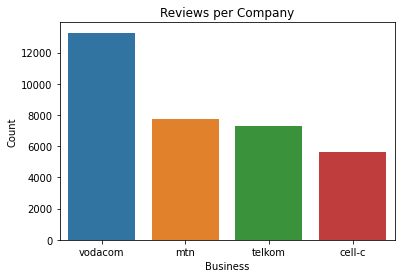

In [79]:
sns.countplot(
    data=df_complaints,
    x='business_slug').set(
    title='Reviews per Company',
    xlabel='Business',
    ylabel='Count')

In [81]:
# perform the under sampling
under_sampler = RandomUnderSampler(random_state=random_seed)
df_complaints_balance, _ = under_sampler.fit_resample(df_complaints, df_complaints.business_slug)

# display the records remaining
show_remaining_count(df_complaints, df_complaints_balance)

(22568) reviews remaining out of (33935) -- 0.67


[Text(0.5, 1.0, 'Reviews after filtering'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'Count')]

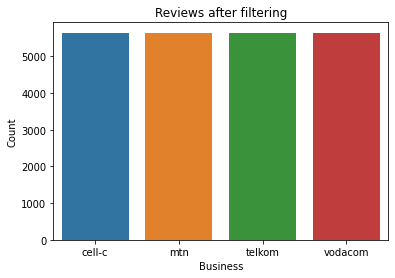

In [82]:
sns.countplot(
    data=df_complaints_balance,
    x='business_slug').set(
    title='Reviews after filtering',
    xlabel='Business',
    ylabel='Count')

In [4]:
custom_stopwords = []
session_id = 2480
target_column = 'review_content_clean'
data = telecom_reviews

# initialize the setup
nlp = setup(
    data=data, 
    target=target_column, 
    session_id=session_id, 
    #custom_stopwords=custom_stopwords
)

Description,Value
session_id,2480
Documents,35072
Vocab Size,21414
Custom Stopwords,False


In [5]:
# create the model
lda = create_model('lda', num_topics = 6, multi_core = True)

In [6]:
#evaluate_model(lda)

In [7]:
# Intrinsic Evaluation using Coherence Value
tuned_unsupervised = tune_model(model = 'lda', multi_core = True)

IntProgress(value=0, description='Processing: ', max=25)

Output()

Best Model: Latent Dirichlet Allocation | # Topics: 16 | Coherence: 0.401


In [29]:
?tuned_unsupervised.get_topics

Signature: tuned_unsupervised.get_topics()
Docstring:
Get the term-topic matrix learned during inference.


Returns
-------
numpy.ndarray
    The probability for each word in each topic, shape (`num_topics`, `vocabulary_size`).
File:      /usr/local/lib/python3.8/site-packages/gensim/models/ldamodel.py
Type:      method


In [31]:
len(tuned_unsupervised.get_topics())

16

In [32]:
?tuned_unsupervised.get_topic_terms

Signature: tuned_unsupervised.get_topic_terms(topicid, topn=10)
Docstring:
Get the representation for a single topic. Words the integer IDs, in constrast to
:meth:`~gensim.models.ldamodel.LdaModel.show_topic` that represents words by the actual strings.

Parameters
----------
topicid : int
    The ID of the topic to be returned
topn : int, optional
    Number of the most significant words that are associated with the topic.

Returns
-------
list of (int, float)
    Word ID - probability pairs for the most relevant words generated by the topic.
File:      /usr/local/lib/python3.8/site-packages/gensim/models/ldamodel.py
Type:      method


In [34]:
tuned_unsupervised.get_topic_terms(1)

[(35, 0.122896634),
 (45, 0.07444717),
 (3, 0.039887287),
 (186, 0.022947488),
 (107, 0.019539213),
 (338, 0.019200733),
 (237, 0.018400816),
 (166, 0.017195355),
 (190, 0.016191084),
 (94, 0.0143295685)]

In [39]:
tuned_unsupervised.ge

Signature: tuned_unsupervised.get_term_topics(word_id, minimum_probability=None)
Docstring:
Get the most relevant topics to the given word.

Parameters
----------
word_id : int
    The word for which the topic distribution will be computed.
minimum_probability : float, optional
    Topics with an assigned probability below this threshold will be discarded.

Returns
-------
list of (int, float)
    The relevant topics represented as pairs of their ID and their assigned probability, sorted
    by relevance to the given word.
File:      /usr/local/lib/python3.8/site-packages/gensim/models/ldamodel.py
Type:      method


In [41]:
tuned_unsupervised.show_topics(formatted=False)

[(14,
  [('upgrade', 0.07544584),
   ('phone', 0.041524798),
   ('order', 0.03389239),
   ('stock', 0.029408315),
   ('receive', 0.028605876),
   ('tell', 0.027320752),
   ('day', 0.021347385),
   ('deliver', 0.020040013),
   ('contract', 0.019767083),
   ('week', 0.019412419)]),
 (11,
  [('contract', 0.15984087),
   ('cancel', 0.08795074),
   ('month', 0.043004677),
   ('cancellation', 0.02280125),
   ('pay', 0.021892905),
   ('end', 0.02180399),
   ('call', 0.020990992),
   ('want', 0.017253319),
   ('still', 0.016614754),
   ('try', 0.01611836)]),
 (1,
  [('service', 0.122896634),
   ('customer', 0.07444717),
   ('bad', 0.039887287),
   ('ever', 0.022947488),
   ('even', 0.019539213),
   ('provider', 0.019200733),
   ('company', 0.018400816),
   ('year', 0.017195355),
   ('never', 0.016191084),
   ('client', 0.0143295685)]),
 (8,
  [('would', 0.020867722),
   ('could', 0.010534617),
   ('deal', 0.010459532),
   ('also', 0.009687204),
   ('information', 0.009655129),
   ('sign', 0.00